In [3]:
#import seaborn as sns
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scipy import stats
import scipy.signal as sg
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

### something to remove a warninig ### arghh
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [4]:
year = 2015

with Dataset(f'../netcdf/{year}/rbr.nc', 'r') as nc:
    
    n_depths = len(nc['DEPTH'][:])
    depth_rbr = np.array(nc['DEPTH'][:])
    temp = np.array(nc['TEMP'][:])
    time = np.array(nc['TIME'][:])
    
time = pd.to_datetime(time, unit='D', origin='1950-01-01 00:00')
df = pd.DataFrame(temp, columns=depth_rbr)
#temp_year = df.to_dict()
means_rbr = df.mean().values 

/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [5]:
df.index = time

In [6]:
df.head()

,800.0,1100.0,1200.0,1300.0,1400.0,1490.0,1540.0,1580.0,1620.0,1660.0
2014-07-29 19:09:59.999990400,9.6494,7.2754,6.4862,6.0981,5.8325,5.4969,5.2323,5.1914,4.9633,4.8976
2014-07-29 19:10:14.999980799,9.6068,7.0359,6.4043,6.0284,5.7819,5.4451,5.1548,5.1159,4.9251,4.8761
2014-07-29 19:10:29.999971200,9.6042,6.9030,6.3854,6.0147,5.7542,5.4278,5.1217,5.0700,4.9076,4.8649
2014-07-29 19:10:44.999961600,9.6017,6.9065,6.3770,6.0082,5.7376,5.4191,5.1029,5.0411,4.8983,4.8595
2014-07-29 19:10:59.999952000,9.6009,6.9101,6.3706,6.0026,5.7251,5.4137,5.0905,5.0160,4.8920,4.8561


# Spectral analysis

In [51]:
np.diff(df.index[:2].values)[0]

numpy.timedelta64(14999990399,'ns')

In [52]:
df.head()

,800.0,1100.0,1200.0,1300.0,1400.0,1490.0,1540.0,1580.0,1620.0,1660.0
2014-07-29 19:09:59.999990400,9.6494,7.2754,6.4862,6.0981,5.8325,5.4969,5.2323,5.1914,4.9633,4.8976
2014-07-29 19:10:14.999980799,9.6068,7.0359,6.4043,6.0284,5.7819,5.4451,5.1548,5.1159,4.9251,4.8761
2014-07-29 19:10:29.999971200,9.6042,6.9030,6.3854,6.0147,5.7542,5.4278,5.1217,5.0700,4.9076,4.8649
2014-07-29 19:10:44.999961600,9.6017,6.9065,6.3770,6.0082,5.7376,5.4191,5.1029,5.0411,4.8983,4.8595
2014-07-29 19:10:59.999952000,9.6009,6.9101,6.3706,6.0026,5.7251,5.4137,5.0905,5.0160,4.8920,4.8561


coriolis = 1.2115139615498907
M2 = 1.932367149758454


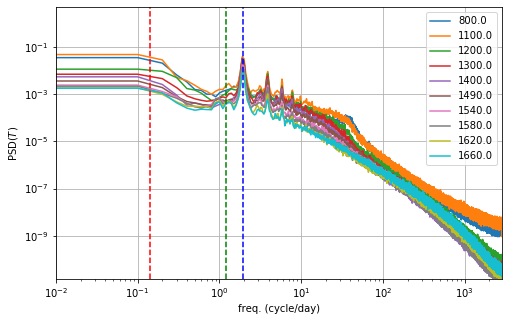

In [53]:
plt.figure(figsize=(8,5))

for depth_k in df.keys():
    temp = df[depth_k].dropna()
    dt = 15/(3600*24) # days! 
    window = 'hanning'
    Lwins = [100,10,1]
    Lwin = Lwins[1]
    freq, psd = sg.welch(temp,fs=1./dt,window=window,detrend='linear',nperseg=int(Lwin/dt))
    plt.loglog(freq,psd, label=depth_k)

plt.ylim([psd[1:].min(),5])

# add typical frequencies
week = 1./7 # yeah, weekly freq.
plt.axvline(week,color='red',alpha=1,ls='--')

lat = 37+.17/.6
Ω = 7.2921e-5
f = 2*np.sin(lat*np.pi/180) # coriolis frequency # where is the angular velocity?
print(f'coriolis = {f}')

plt.axvline(f,color='green',alpha=1,ls='--')
M2 = 24/12.42 # M2
print(f'M2 = {M2}')
plt.axvline(M2,color='blue',alpha=1,ls='--')

# Nmin = 3.56e-3/2/np.pi*3600*24 # Brunt-Vaisala? I need to compute from my data.
# plt.axvline(Nmin,color='red',alpha=1,ls='--')

# Nmax = 3.63e-3/2/np.pi*3600*24 #B-V freq.? 
# plt.axvline(Nmax,color='red',alpha=1,ls='--')

plt.grid(True)
plt.xlim([1e-2,freq.max()])
plt.xlabel('freq. (cycle/day)')
plt.ylabel(r'PSD($T$)')
plt.legend()

# Ridge plot 

# Guillaume's idea

switched the histogram curve for a Kernel density estimation curve because it looks nicer.

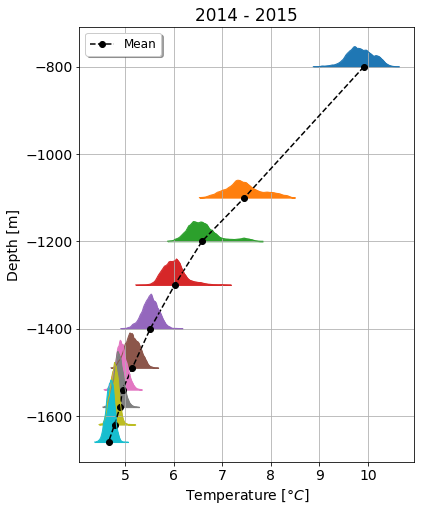

In [118]:
levels = df.keys()
means = df.mean().values 

fig, ax = plt.subplots(1, figsize=(6,8))
ax.plot(means, -levels, 'ko--', label='Mean')

colors = plt.rcParams["axes.prop_cycle"]()

for i, key in enumerate(levels):
    c = next(colors)['color']
    val_min = df[key].min()
    val_max = df[key].max()
    x_values = np.linspace(val_min, val_max, 64)
    base_line = np.zeros_like(x_values) - levels[i]

    kernel = stats.gaussian_kde(df[key].dropna())
    kde = kernel(x_values)*30 - levels[i]

    ax.plot(x_values, kde, color=c, lw=1)
    ax.fill_between(x_values, base_line, kde, alpha=1, color=c)

ax.set_xlabel(r'Temperature [$\degree C$]')
ax.set_ylabel('Depth [m]')
ax.set_title(f'{year-1} - {year}')
ax.grid()
ax.legend(fontsize=12, shadow=True)

## comparing years

In [2]:
depths_year = {}

for y in range(2011,2020):
    with Dataset(f'../../netcdf/{y}/rbr.nc', 'r') as nc:
        depths_global[y] = np.array(nc['DEPTH'][:])


In [3]:
depths_global

{2011: array([1200., 1300., 1400.], dtype=float32),
 2012: array([1100., 1200., 1300., 1400., 1490., 1540., 1580., 1620., 1660.],
       dtype=float32),
 2013: array([1100., 1200., 1300., 1400., 1500., 1540., 1580., 1620., 1660.],
       dtype=float32),
 2014: array([ 800., 1100., 1200., 1300., 1400., 1540., 1580., 1620., 1660.],
       dtype=float32),
 2015: array([ 800., 1100., 1200., 1300., 1400., 1490., 1540., 1580., 1620.,
        1660.], dtype=float32),
 2016: array([ 800., 1200., 1300., 1400., 1540., 1580., 1620., 1660.],
       dtype=float32),
 2017: array([ 780.,  943., 1190., 1289., 1382., 1458., 1507., 1557., 1606.,
        1665.], dtype=float32),
 2018: array([ 800.,  900., 1200., 1300., 1350., 1490., 1540., 1580., 1620.,
        1660.], dtype=float32),
 2019: array([ 800.,  900., 1200., 1300., 1350., 1490., 1540., 1580., 1620.,
        1660.], dtype=float32)}

In [ ]:
levels = df.keys()
means = df.mean().values 

fig, ax = plt.subplots(1, figsize=(6,8))
ax.plot(means, -levels, 'ko--', label='Mean')

colors = plt.rcParams["axes.prop_cycle"]()

for i, key in enumerate(levels):
    c = next(colors)['color']
    val_min = df[key].min()
    val_max = df[key].max()
    x_values = np.linspace(val_min, val_max, 64)
    base_line = np.zeros_like(x_values) - levels[i]

    kernel = stats.gaussian_kde(df[key].dropna())
    kde = kernel(x_values)*30 - levels[i]

    ax.plot(x_values, kde, color=c, lw=1)
    ax.fill_between(x_values, base_line, kde, alpha=0.7, color=c)

ax.set_xlabel(r'Temperature [$\degree C$]')
ax.set_ylabel('Depth [m]')
ax.set_title(f'{year-1} - {year}')
ax.grid()
ax.legend(fontsize=12, shadow=True)

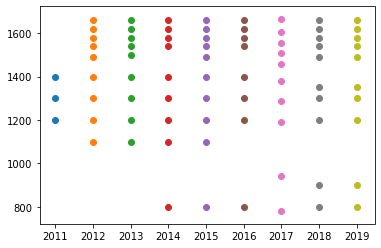

In [4]:
for y in range(2011,2020):
    x = np.zeros(len(depths_global[y])) + y
    plt.scatter(x, depths_global[y])

In [21]:
temp_1200[2011].mean()

6.4301305

In [27]:
with Dataset(f'../netcdf/{2017}/rbr.nc', 'r') as nc:
    print(nc.variables)

OrderedDict([('TIME', <class 'netCDF4._netCDF4.Variable'>
float64 TIME(time)
    long_name: Julian day (UTC) of the station relative to 1950-01-01 00:00:00 UTC
    standard_name: time
    reference_date: 1950-01-01 00:00:00 UTC
    units: days
    conventions: Relative julian days with decimal part (as parts of day)
    axis: T
unlimited dimensions: 
current shape = (1745017,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('TEMP', <class 'netCDF4._netCDF4.Variable'>
float32 TEMP(time, levels)
    long_name: Sea temperature in-situ ITS-90 scale
    standard_name: sea_water_temperature
    units: degC
    valid_min: -2.5
    valid_max: 40.0
    resolution: 0.001
unlimited dimensions: 
current shape = (1745017, 10)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('DEPTH', <class 'netCDF4._netCDF4.Variable'>
float32 DEPTH(levels)
    description: theoretical depth of each instrument on the line
    long_name: Depth of each measurement
    standard_name: de

In [110]:
temp_1200 = {}
i_level = 1200
for y in range(2011,2020):
    with Dataset(f'../netcdf/{y}/rbr.nc', 'r') as nc:
        depth_y = np.array(nc['DEPTH'][:])
        
        #print(y, depth_y)
        
        if y==2017:
            idx = np.where(depth_y==1190)[0]
            print(idx)
            temp_1200[y] = np.array(nc['TEMP'][:,2])
            continue
        
        idx = np.where(depth_y==i_level)[0]
                
        #print(y, idx)
        for i in idx:
            temp_1200[y] = np.array(nc['TEMP'][:,i])

            
with Dataset(f'../netcdf/{2017}/rbr.nc', 'r') as nc:
    temp_1200[2017] = np.array(nc['TEMP'][:,2])

/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/Users/claudiopierard/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


[2]


In [111]:
temp_1200

{2011: array([6.4187, 6.4166, 6.4154, ..., 6.3703, 6.4398, 6.4898], dtype=float32),
 2012: array([5.8728, 5.8736, 5.8744, ..., 6.7024, 6.7026, 6.7027], dtype=float32),
 2013: array([6.6832, 6.6775, 6.6757, ..., 6.3156, 6.316 , 6.3171], dtype=float32),
 2014: array([6.8705, 6.8608, 6.8561, ...,    nan,    nan,    nan], dtype=float32),
 2015: array([6.4862, 6.4043, 6.3854, ..., 6.736 , 6.7292, 6.7255], dtype=float32),
 2016: array([6.9144, 6.9141, 6.9137, ...,    nan,    nan,    nan], dtype=float32),
 2017: array([6.7543, 6.6583, 6.5579, ..., 6.2661, 6.2658, 6.2656], dtype=float32),
 2018: array([7.4956193, 7.4152355, 7.2998476, ..., 8.3701935, 8.6047945,
        8.548303 ], dtype=float32),
 2019: array([6.8253374, 6.8259063, 6.826112 , ..., 6.881129 , 6.98888  ,
        7.07033  ], dtype=float32)}

In [107]:
def ridge_plot(data, xlabel, bins=128, h_space=-0.5, alpha=1, figsize=(8,8), cmap='tab10'):

    nrows = len(data.keys())
    labels = list(temp_1200.keys())
    
    x_colors = np.linspace(0,1, nrows)
    colors = cm.get_cmap(cmap)(x_colors)
    
    fig, axes = plt.subplots(nrows,  sharex=True, figsize=figsize)
    
    min_glob = 999

    for i, key in enumerate(data.keys()):
        val_min = data[key][~np.isnan(data[key])].min()
        val_max = data[key][~np.isnan(data[key])].max()
        
        if val_min < min_glob:
            min_glob = val_min
    
        x_values = np.linspace(val_min, val_max, bins)

        c = colors[i]
        
        kernel = stats.gaussian_kde(data[key][~np.isnan(data[key])])
        kde = kernel(x_values)

        axes[i].plot(x_values, kde, color="#f0f0f0", lw=1)
        
        axes[i].fill_between(x_values, kde, color=c, alpha=alpha)
        rect = axes[i].patch
        rect.set_alpha(0)
        axes[i].tick_params(left=False, labelleft=False)

        if i == len(data.keys())-1:
            axes[i].tick_params(bottom=True, left=False, labelleft=False)
            spines = ["top","right","left"]
            axes[i].set_ylim(-0.05,)
            axes[i].set_xlim(min_glob,)
            axes[i].set_xlabel(xlabel, fontsize=14)

        else:
            axes[i].tick_params(bottom=False, left=False, labelleft=False)
            spines = ["top","right","left","bottom"]

        for s in spines:
            axes[i].spines[s].set_visible(False)

        depth_label = str(int(key))
        
    for j,l in enumerate(data.keys()): 
        axes[j].text(min_glob, 0.05, labels[j], fontweight="bold", fontsize=13, ha="right")

    plt.subplots_adjust(hspace=h_space)


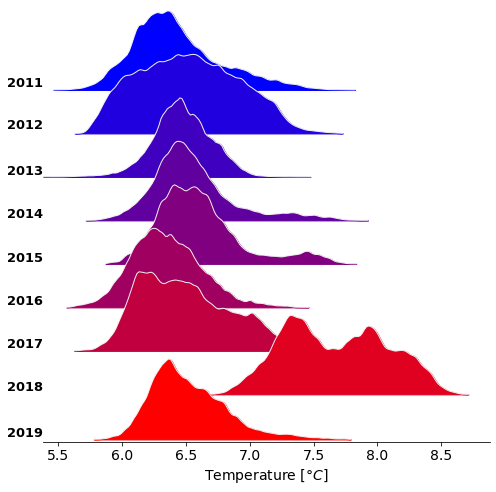

In [112]:
ridge_plot(temp_1200, r'Temperature [$\degree C$]', cmap=my_cmap)

In [37]:
from matplotlib.colors import LinearSegmentedColormap


def display_cmap(cmap):
    plt.imshow(np.linspace(0, 100, 256)[None, :],  aspect=25,    interpolation='nearest', cmap=cmap) 
    plt.axis('off')

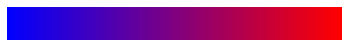

In [102]:
basic_cols=['blue', 'red']
my_cmap=LinearSegmentedColormap.from_list('mycmap', basic_cols)
display_cmap(my_cmap)

In [58]:
my_cmap.N

256

In [59]:
from matplotlib import cm

In [63]:
x = np.linspace(0.0, 1.0, 10)

In [65]:
cm.get_cmap('inferno')(0)

(0.001462, 0.000466, 0.013866, 1.0)